In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import GPy

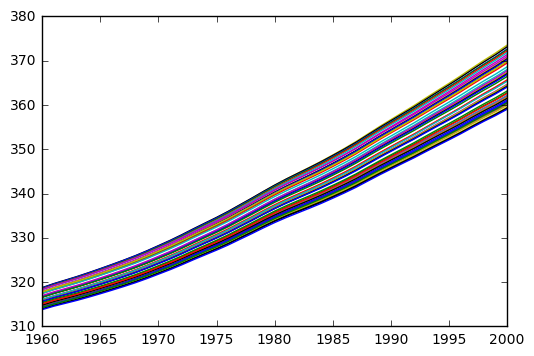

In [54]:
#y = np.genfromtxt('https://raw.githubusercontent.com/rich-d-wilkinson/PEN_Labs/master/UVic_y.csv', delimiter=',', skip_header=1)
y = np.genfromtxt('simco2.csv', delimiter=',', skip_header=1)
y=y.T
y=y[1:,:]
for i in range(y.shape[0]):
    plt.plot(np.arange(1960, 2001,1), y[i,:])
plt.show()

[ 316.91  317.65  318.45  318.99  319.2   320.03  321.37  322.18  323.05
  324.62  325.68  326.32  327.46  329.68  330.25  331.15  332.15  333.9
  335.5   336.85  338.69  339.93  341.13  342.78  344.42  345.9   347.15
  348.93  351.48  352.91  354.19  355.59  356.37  357.04  358.88  360.88
  362.64  363.76  366.63  368.31  369.48]


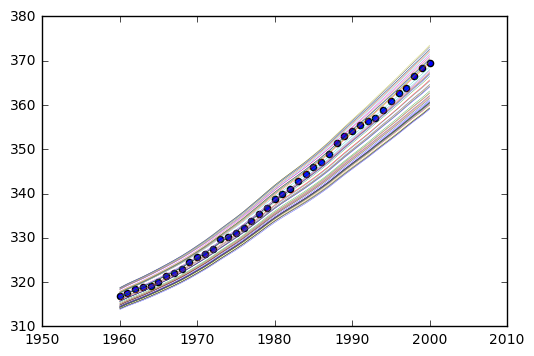

In [55]:
yobs = np.genfromtxt('fieldco2.csv', delimiter=',', skip_header=1)
yobs=yobs[:,1]
print(yobs)
for i in range(y.shape[0]):
    plt.plot(np.arange(1960, 2001,1), y[i,:], linewidth=0.2 )
plt.scatter(np.arange(1960, 2001,1), yobs[keep])
plt.show()



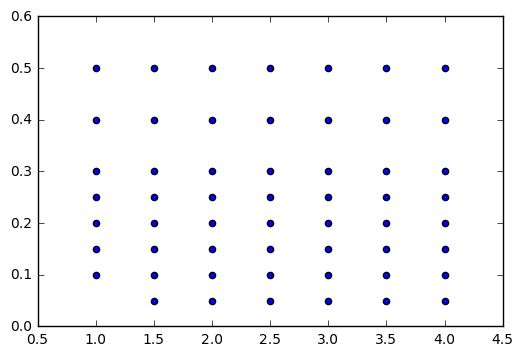

In [56]:
X = np.genfromtxt('https://raw.githubusercontent.com/rich-d-wilkinson/PEN_Labs/master/UVic_x.csv', delimiter=',', skip_header=1)
plt.scatter(X[:,0], X[:,1])

In [58]:
yobs.shape

(41,)

(55, 41)

In [59]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(y)

PCA(copy=True, n_components=2, whiten=False)

In [72]:
y_proj = pca.transform(y)


In [73]:
k1 =GPy.kern.RBF(2, ARD=True)
m1 = GPy.models.GPRegression(X, y_proj[:,0].reshape((X.shape[0],1)), k1)
m1.optimize_restarts(10)
print(m1)


Optimization restart 1/10, f = 88.9824538249068
Optimization restart 2/10, f = 88.98245382557602
Optimization restart 3/10, f = 88.98245382490103
Optimization restart 4/10, f = 88.98245382489796
Optimization restart 5/10, f = 88.98245382591543
Optimization restart 6/10, f = 88.98245382497042
Optimization restart 7/10, f = 88.98245382492279
Optimization restart 8/10, f = 88.9824538414292
Optimization restart 9/10, f = 88.98245382615752
Optimization restart 10/10, f = 88.98245385733867

Name : GP regression
Objective : 88.98245382489796
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |           value  |  constraints  |  priors
  rbf.variance             |   475.534688216  |      +ve      |        
  rbf.lengthscale          |            (2,)  |      +ve      |        
  Gaussian_noise.variance  |  0.509079834206  |      +ve      |        


In [74]:


yobs_proj = pca.transform(yobs[None,:])
yobs_proj

array([[ 14.7633426,   4.0248833]])

$Q_10\sim U[1,4] \qquad K_c \sim U[0.25, 0.6]$

In [95]:
Q10 = np.random.rand(1000,1)*3+1
Kc = np.random.rand(1000,1)*0.35+0.25
Xpred = np.concatenate((Q10, Kc), axis=1)

In [107]:
yobs_proj[0,0]

14.763342600903458

(0.25, 0.6)

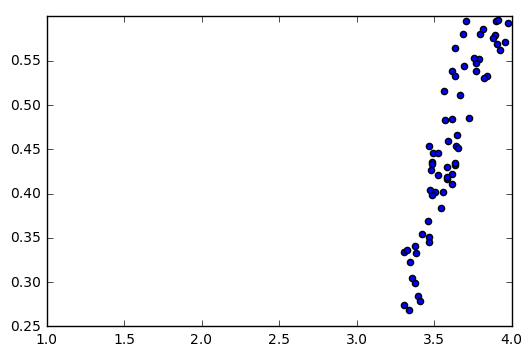

In [121]:
mu, V = m1.predict(Xpred)

Implausibility = (mu-yobs_proj[0,0])**2/(V)
keep = Implausibility<=3**2
keep.shape
Xpred.shape
plt.scatter(Xpred[keep.flatten(),0], Xpred[keep.flatten(),1])
axes=plt.gca()
axes.set_xlim(1,4)
axes.set_ylim(0.25,0.6)


## Non-Gaussian likelihoods

Considered the olympic marathon data that we use as a running example in many of our other notebooks. In 1904 we noted there was an outlier example. Today we'll see if we can deal with that outlier by considering a non-Gaussian likelihood. Noise sampled from a Student-t density is heavier tailed than that sampled from a Gaussian. However, it cannot be trivially assimilated into the Gaussian process. Below we use the Laplace approximation to incorporate this noise model.

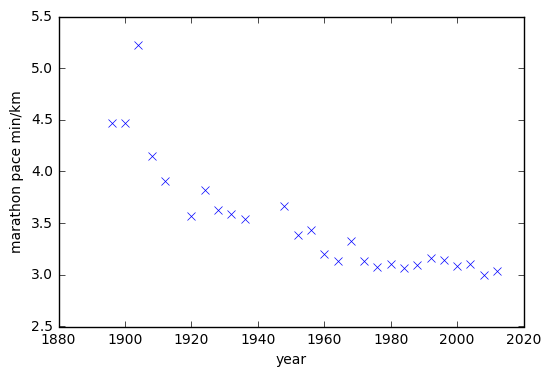

In [122]:
# Download the marathon data from yesterday and plot
GPy.util.datasets.authorize_download = lambda x: True # prevents requesting authorization for download.
data = GPy.util.datasets.olympic_marathon_men()
X = data['X']
Y = data['Y']

plt.plot(X, Y, 'bx')
plt.xlabel('year')
plt.ylabel('marathon pace min/km')

We might want to use a non-Gaussian likelihood here. This also means that our inference method can no longer be exact, and we have to use one of the approximate methods. Lets use a Student-T distribution that has heavy tails to allow for the outliers without drastically effecting the posterior mean of the GP.

In [123]:
GPy.likelihoods.StudentT?

### Laplace

 /Users/pmzrdw/GPy/GPy/inference/latent_function_inference/laplace.py:225: UserWarning:Not perfect mode found (f_hat). difference: 0.000476202277713611, iteration: 30 out of max 30
 /Users/pmzrdw/GPy/GPy/inference/latent_function_inference/laplace.py:229: UserWarning:f_hat now fine again. difference: 3.999971140800085e-05, iteration: 11 out of max 30


gp.,value,constraints,priors
sum.rbf.variance,0.276023897238,+ve,
sum.rbf.lengthscale,18.4860718934,+ve,
sum.bias.variance,5.9828765131,+ve,
Student_T.t_scale2,0.00486688115521,+ve,
Student_T.deg_free,1.76641264418,+ve,


 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


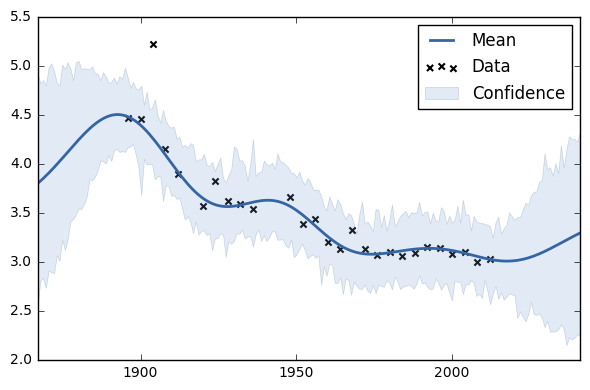

In [124]:
t_distribution = GPy.likelihoods.StudentT(deg_free=5.0, sigma2=2.0)
laplace = GPy.inference.latent_function_inference.Laplace()

kern = GPy.kern.RBF(1, lengthscale=5) + GPy.kern.Bias(1, variance=4.0)
m_stut = GPy.core.GP(X, Y, kernel=kern, inference_method=laplace, likelihood=t_distribution)

m_stut.optimize()
m_stut.plot(plot_density=False)

m_stut

### EP

If we instead wanted to perform classification, it might be that we want to use Expectation Propagation (EP). Currently EP only works on a couple of likelihoods, namely the Bernoulli likelihood

In [125]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import cPickle as pickle
import urllib

urllib.urlretrieve('http://staffwww.dcs.sheffield.ac.uk/people/M.Zwiessele/gpss/lab2/EastTimor.pickle', 'EastTimor2.pickle')

#Load the data
with open("./EastTimor2.pickle","rb") as f:
    Xeast,Yeast,polygons = pickle.load(f)

ImportError: No module named 'cPickle'

Now we will create a map of East Timor and, using GPy, plot the data on top of it. A classification model can be defined in a similar way to the laplace regression model, but now using GPy.inference.latent_function_inference.EP(). A wrapper for a classification model using EP is given by GPy.models.GPClassification()

In [28]:
ep = GPy.inference.latent_function_inference.EP()
kern = GPy.kern.RBF(2, lengthscale=0.6, ARD=True)
bern = GPy.likelihoods.Bernoulli()
m_ep = GPy.core.GP(Xeast, Yeast, kernel=kern, inference_method=ep, likelihood=bern)


fig = plt.figure()
ax = fig.add_subplot(111)
for p in polygons:
    ax.add_collection(PatchCollection([Polygon(p)],facecolor="#F4A460"))
ax.set_xlim(124.,127.5)
ax.set_ylim(-9.6,-8.1)
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")

m_ep.plot(ax=ax)

NameError: name 'Xeast' is not defined

Now we optimize the hyper-parameters

In [ ]:
m_ep.optimize()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
for p in polygons:
    ax.add_collection(PatchCollection([Polygon(p)],facecolor="#F4A460"))
ax.set_xlim(124.,127.5)
ax.set_ylim(-9.6,-8.1)
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")

m_ep.plot(ax=ax)


# Sparse GPs